In [148]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [149]:
df = pd.read_csv('features.csv')  

In [150]:
df.head()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [151]:
X.head()

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_Ratio,D5_Ratio,D4_Ratio,D3_Ratio,D2_Ratio,...,D4_mean,D3_mean,D2_mean,D1_mean,D6_mean_abs,D5_mean_abs,D4_mean_abs,D3_mean_abs,D2_mean_abs,D1_mean_abs
0,369.120037,352.542350,219.789014,50.057098,11.317664,1.412244,0.786319,1.622369,0.636899,0.502254,...,2.521310,1.710888,-0.088914,-0.024502,166.075471,117.596905,133.031739,46.400020,12.674264,4.069521
1,170.272780,91.248519,81.837360,57.813681,16.141807,1.130649,1.031881,0.917942,1.381581,0.663050,...,-6.183026,1.970947,0.153614,-0.036580,93.072748,82.318008,66.476720,62.520630,24.029208,9.960218
2,179.528459,206.243281,258.537856,83.399922,18.367247,1.389559,0.597221,1.833507,1.008122,0.501076,...,-4.911867,1.762548,0.000942,0.027263,88.221607,63.488905,124.392681,72.199336,18.842634,3.009377
3,247.653592,109.859448,109.286705,45.426403,11.268524,1.048850,1.050830,1.082920,1.089004,0.667683,...,-2.581610,-0.440224,0.020637,-0.059357,93.309338,88.963472,76.011128,51.418320,18.420735,3.759779
4,206.941133,55.878810,54.317202,25.280431,6.312881,1.535573,0.819585,1.070052,1.208973,0.627818,...,0.713725,0.747502,0.043122,-0.077302,89.556146,58.320987,52.762225,40.295235,13.898048,3.978906


In [152]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: class, dtype: int64

# Cross-validation

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2, 
                                                    random_state=0)

# define our classifier pipelines

In [154]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE=0

# Logistic Regression
pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE, 
                            class_weight = 'balanced')

# Random Forest
rf = Pipeline([('clf', RandomForestClassifier(random_state=RANDOM_STATE, 
                            class_weight = 'balanced'))])

# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

# list of classifier names
classifier_names = ['Logistic Regression', 'Support Vector Machine', 
                    'Decision Tree', 'Random Forest', 'K-Nearest Neighbors']

# list of classifiers
classifiers = [pipe_reg, pipe_svc, DT, rf, pipe_kkn]

# fit all the classifiers to the training data
# for classifier in classifiers:
#     classifier.fit(X_train, y_train)

## K-Fold Cross-validation

There is a disadvantage to the holdout method, as where the splits of the training, validation, and test sets are will effect performance. Therefore a more robust technique is to split the training data into multipule training and validation sets (e.g. K-Fold Cross-Validation). We randomly split the training set into k folds without replacement so k-1 folds are used for model training with one fold used for performance evaluation. As this is repeated k times we get k models and performance estimates, of which the average performance is taken. As the k-fold cross-validation resamples without replacement, each sample point will have been used in both the training and validation sets once

In [155]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import numpy as np

StratKFold = StratifiedKFold(n_splits = 5,
                             shuffle=False,
                             random_state=0)

SCORER = make_scorer(score_func=f1_score)

scores = cross_val_score(estimator=pipe_reg, 
                         X=X_train, 
                         y=y_train, 
                         cv=StratKFold,
                         scoring = SCORER,
                         n_jobs=-1)

print('CV F1 scores: %s' % scores)
print('CV F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CV F1 scores: [0.83333333 0.76923077 0.75675676 0.86486486 0.86486486]
CV F1: 0.818 +/- 0.046


# Grid search CV

A grid search is an exhaustive search paradigm where we specify a list inside a dictionary with various values for different hyperparameters. The computer will use this list to evaluate the model performance for each combination of values to obtain the set that scorers best on the given performance metric1.

In [156]:
from sklearn.externals import joblib
from sklearn.model_selection  import GridSearchCV

SCORER = make_scorer(score_func=f1_score)

# make a parameter grid with the range of hyperparameteer values of interest
PARAM_GRID = {'clf__C': np.logspace(-3,3,7)}

def Grid_Search(X_train, y_train, estimator, cv, 
                param_grid, scorer):

    # create gridsearch object
    gs = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid, 
                    scoring=scorer, 
                    cv=cv,
                    return_train_score=True,
                    refit = True,
                    n_jobs=-1)

    # fit the gridsearch object
    gs = gs.fit(X_train, y_train)

    # get the results of the gridsearch
    results = pd.DataFrame(gs.cv_results_)

    # select the best estimator
    clf_pipe = gs.best_estimator_

    display(results[['mean_fit_time','mean_score_time',
                   'params','mean_test_score',
                   'std_test_score']].sort_values(by='mean_test_score',
                                                  ascending =False))

    return clf_pipe, results


## Run grid search CV to find the regularization parameter that gives the best F1 score on the validation sets

In [157]:
best_reg_pipe, reg_grid_results = Grid_Search(X_train, y_train, pipe_reg, 
                                              StratKFold, PARAM_GRID, SCORER)

,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
6,0.017166,0.002086,{'clf__C': 1000.0},0.904908,0.048790
5,0.011520,0.005023,{'clf__C': 100.0},0.879694,0.039702
4,0.010483,0.003023,{'clf__C': 10.0},0.837936,0.020291
3,0.009661,0.004592,{'clf__C': 1.0},0.817810,0.046383
2,0.007886,0.007793,{'clf__C': 0.1},0.744377,0.046476
1,0.008584,0.004472,{'clf__C': 0.01},0.677165,0.036860
0,0.006034,0.002295,{'clf__C': 0.001},0.606075,0.037165


## Run Gridsearch CV on RandomForest to find the tree parameters that gives the best F1 score on the validation sets

In [158]:
PARAM_GRID_RF = {'clf__max_depth': [5, 10, 15, 25],
                'clf__n_estimators': [500, 1000],
                'clf__min_samples_split': [5, 10, 20]}

best_reg_pipe, reg_grid_results = Grid_Search(X_train, y_train, rf, 
                                              StratKFold, PARAM_GRID_RF, SCORER)


,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
12,1.719729,0.107164,"{'clf__max_depth': 15, 'clf__min_samples_split...",0.885444,0.065069
6,1.794599,0.103141,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.885444,0.065069
13,3.249057,0.193468,"{'clf__max_depth': 15, 'clf__min_samples_split...",0.885444,0.065069
19,3.466465,0.202870,"{'clf__max_depth': 25, 'clf__min_samples_split...",0.885444,0.065069
7,3.520250,0.198340,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.885444,0.065069
18,1.772410,0.105527,"{'clf__max_depth': 25, 'clf__min_samples_split...",0.885444,0.065069
10,1.810254,0.108410,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.879827,0.045302
22,1.471747,0.088154,"{'clf__max_depth': 25, 'clf__min_samples_split...",0.879827,0.045302
16,1.739167,0.105552,"{'clf__max_depth': 15, 'clf__min_samples_split...",0.879827,0.045302
5,3.585433,0.216947,"{'clf__max_depth': 5, 'clf__min_samples_split'...",0.875065,0.048569


In [159]:
best_reg_pipe

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [160]:
summary = reg_grid_results[['param_clf__max_depth', 'param_clf__n_estimators', 'param_clf__min_samples_split', 'mean_train_score', 'mean_test_score']]

In [161]:
print(max(summary['mean_test_score']))

0.8854437229437229


In [162]:
summary_long = pd.melt(summary, 
                       id_vars=['param_clf__max_depth', 
                                'param_clf__n_estimators',
                               'param_clf__min_samples_split'],
                       value_vars=['mean_train_score', 
                                   'mean_test_score'],
                        var_name='metric',
                      value_name='score')

In [163]:
summary_long

,param_clf__max_depth,param_clf__n_estimators,param_clf__min_samples_split,metric,score
0,5,500,5,mean_train_score,0.963973
1,5,1000,5,mean_train_score,0.963973
2,5,500,10,mean_train_score,0.961013
3,5,1000,10,mean_train_score,0.959598
4,5,500,20,mean_train_score,0.932679
5,5,1000,20,mean_train_score,0.931308
6,10,500,5,mean_train_score,1.000000
7,10,1000,5,mean_train_score,1.000000
8,10,500,10,mean_train_score,0.996899
9,10,1000,10,mean_train_score,0.995349


In [164]:
import seaborn as sns

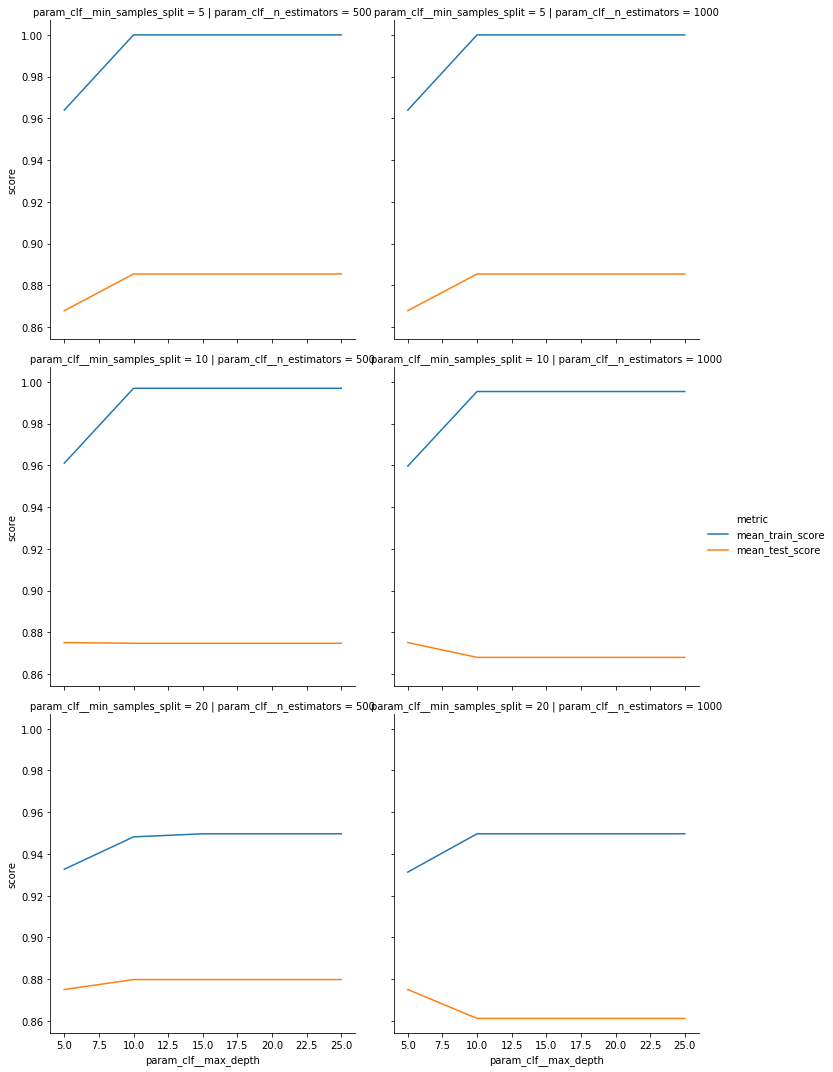

In [165]:
g = sns.relplot(data=summary_long,
               x = 'param_clf__max_depth',
               y ='score',
               row='param_clf__min_samples_split',
               col='param_clf__n_estimators',
               hue='metric',
               kind='line')

# Evaluate best random forest model on the test set

In [166]:
# Random Forest
# rf = Pipeline([('clf', RandomForestClassifier(random_state=RANDOM_STATE, 
#                                               class_weight = 'balanced',
#                                               min_samples_split=5,
#                                               n_estimators=1000,
#                                               max_depth=10
#                                              ))])

best_reg_pipe.fit(X_test, y_test)

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [167]:
from sklearn.metrics import classification_report
predictions = best_reg_pipe.predict(X_test)

pd.DataFrame(classification_report(y_test, 
                                   predictions, 
                                   labels=None, 
                                   target_names=['Baseline', 'Seizure'], 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True))

,Baseline,Seizure,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,80.0,20.0,1.0,100.0,100.0


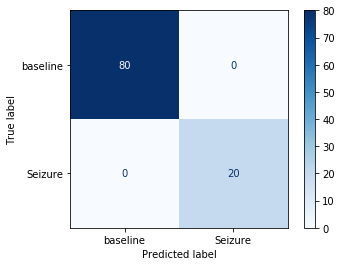

In [168]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_reg_pipe, X_test, y_test,
                                 display_labels=['baseline', 'Seizure'],
                                 cmap=plt.cm.Blues)